### EDA
#### Step 1 : 分析各產業別之間的異常報酬率

In [1]:
import pandas as pd
import seaborn as sns
import bokeh as bok
df_fs_return=pd.read_csv("上市櫃公司_plus異常報酬率.csv")

In [2]:
import numpy as np
df_fs_return_columns=df_fs_return.columns[52:]
return_industry=df_fs_return.groupby(by="TSE產業名稱")[df_fs_return_columns].mean()
print("資料集大小 :",return_industry.shape)
print(f"總計有{df_fs_return['TSE產業名稱'].nunique()}種產業類別")

資料集大小 : (35, 131)
總計有35種產業類別


### 動態圖表 : 完全由Gemini pro 3 製作

#### df.melt() = 將寬資料轉換成長資料，以符合製圖模組的需求
#### 使用說明 :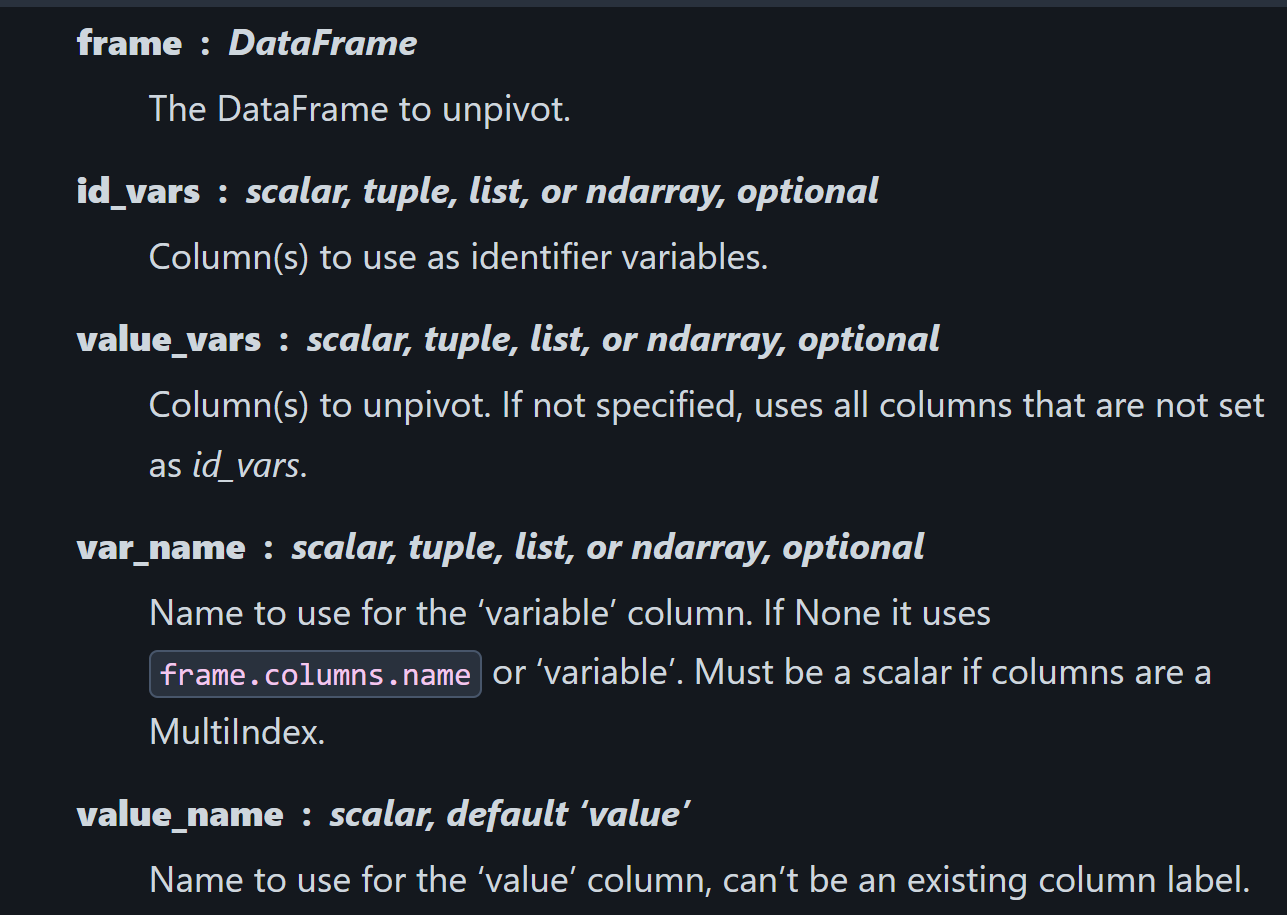
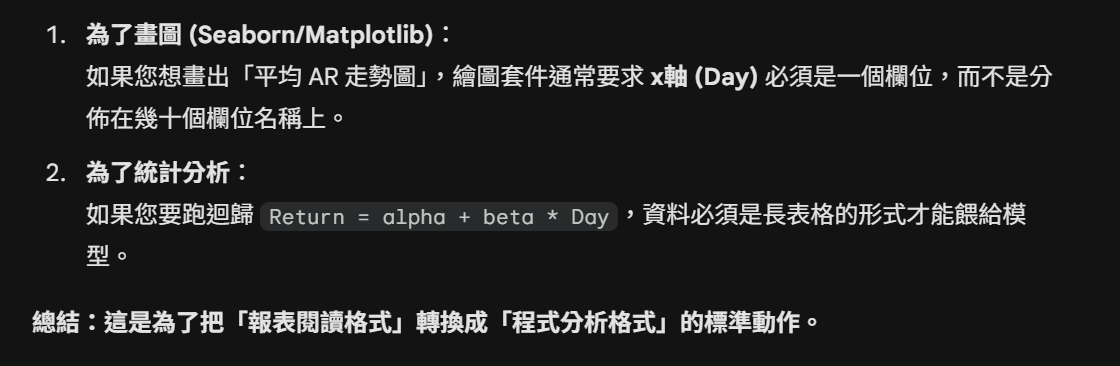
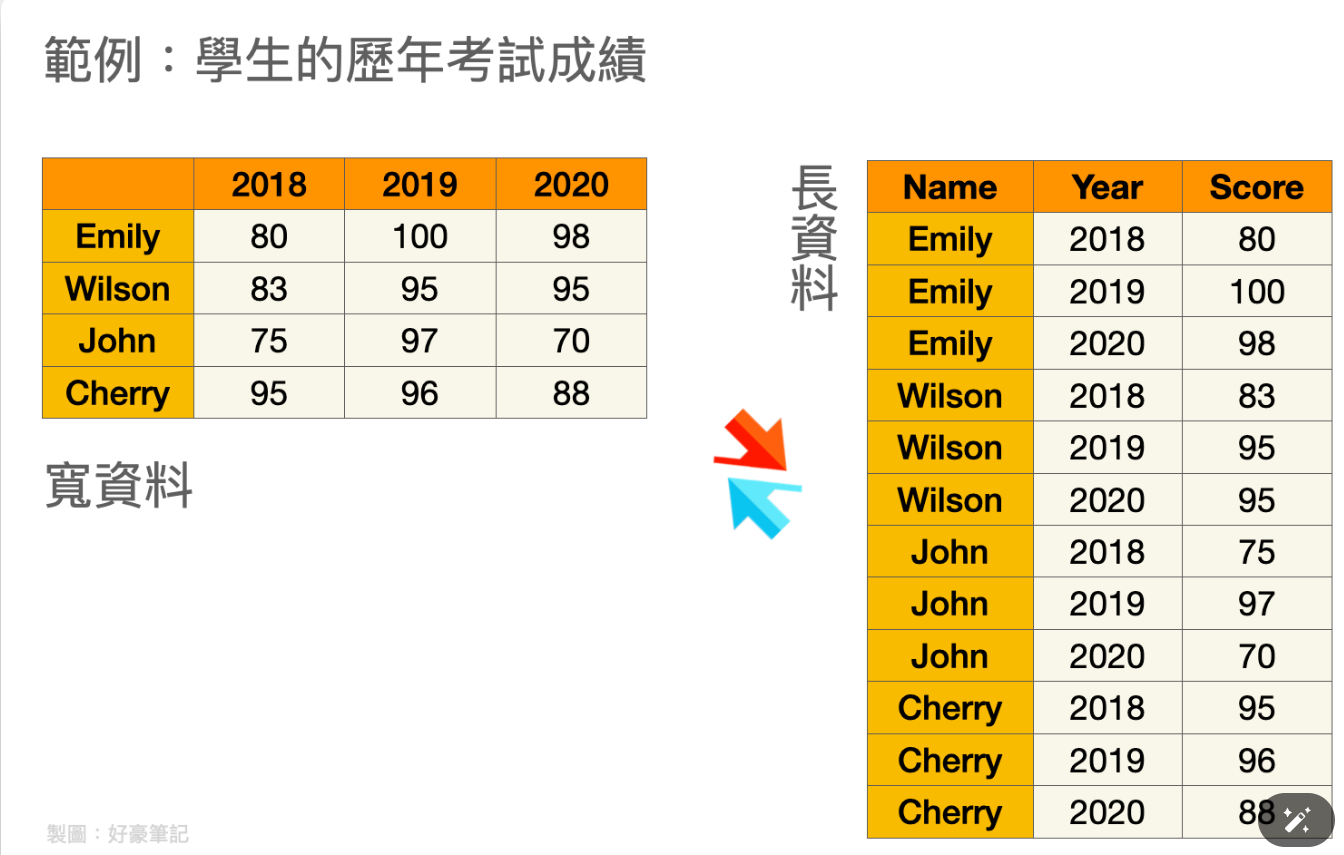
#### <span style="color : #2c5344"> px.colors.qualitative函式內容:
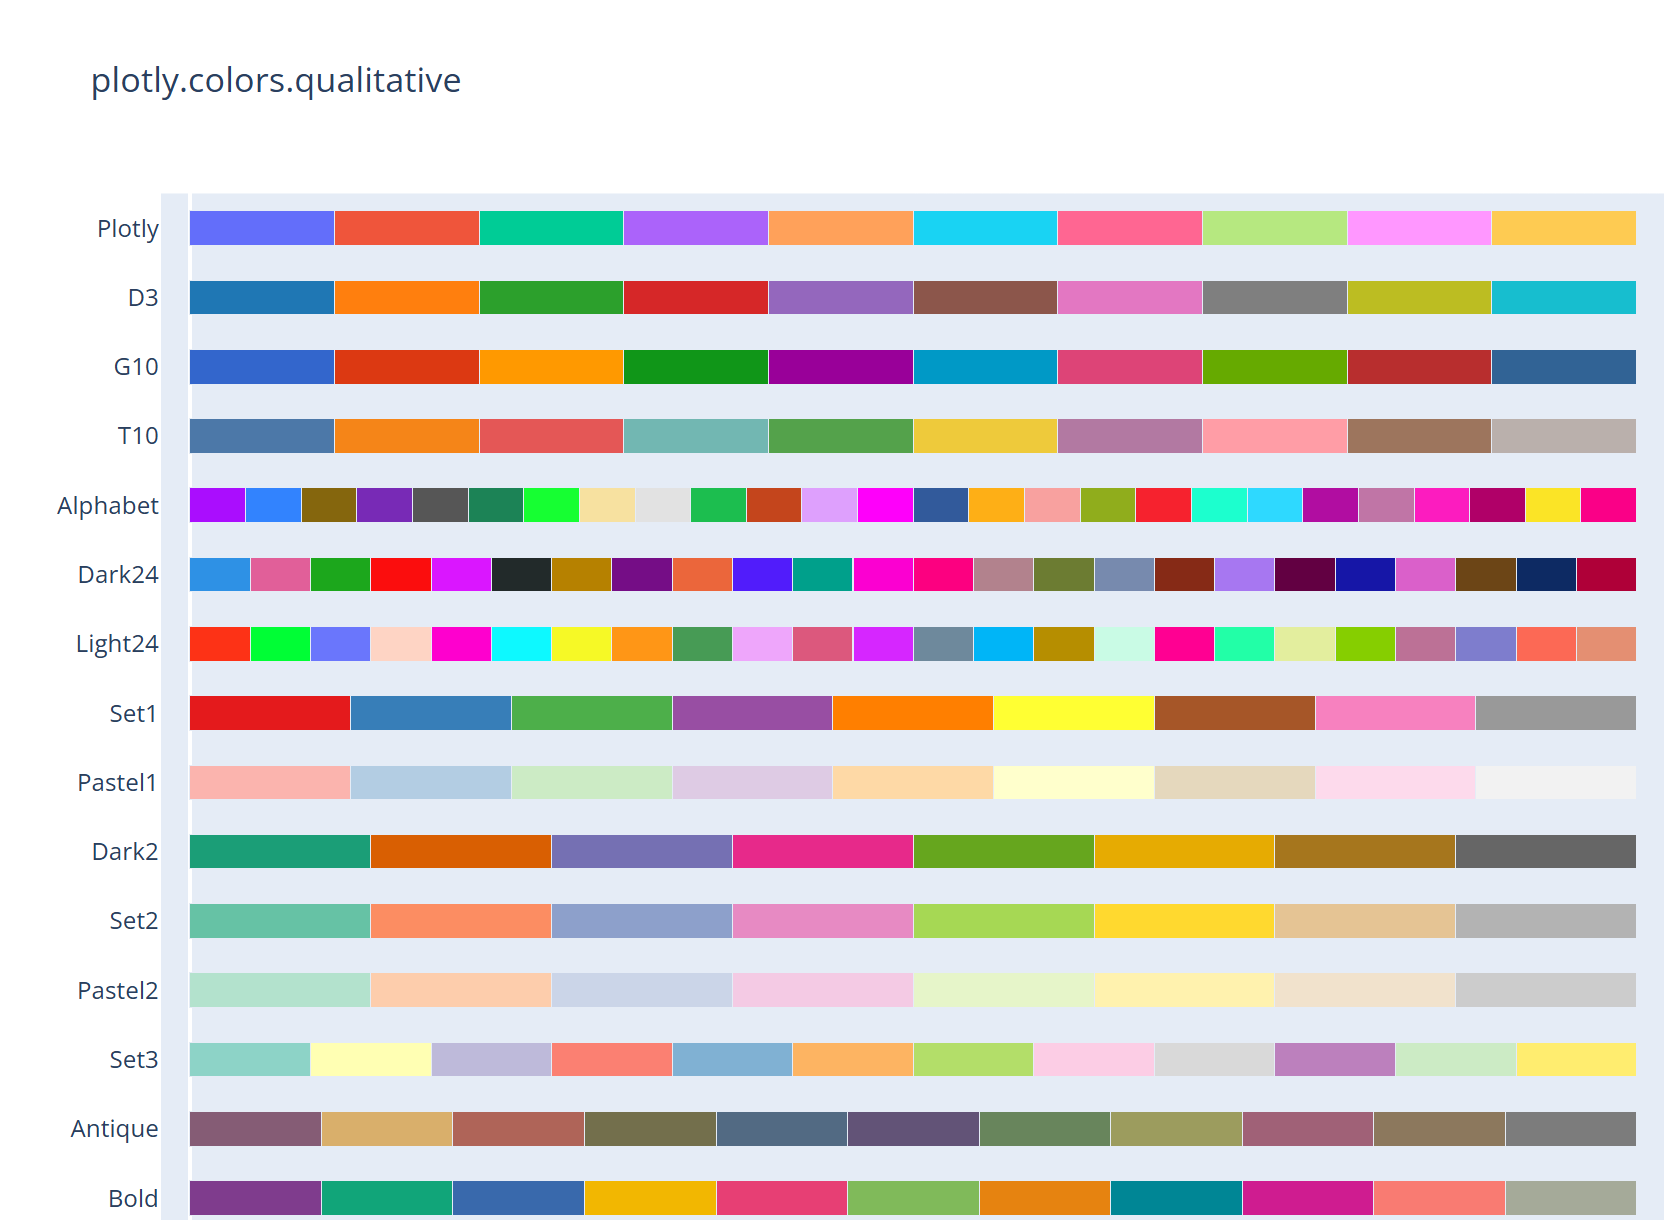

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. 讀取資料
df = pd.read_csv('return_industry.csv')

# 清除可能存在的雜訊欄位
if 'Unnamed: 182' in df.columns:
    df = df.drop(columns=['Unnamed: 182'])

if '平均值' in df.columns:
    df = df.drop(columns=['平均值'])

# 2. 資料轉置：從 Wide Format 轉為 Long Format
# id_vars 是固定欄位 (產業名稱)，其餘欄位都是時間點
id_col = df.columns[0]  # 'TSE產業名稱'
time_cols = df.columns[1:]  # '-10', '-9', ... 等時間欄位

df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

# 3. 資料清理：將天數轉為整數並排序
df_long['Day'] = df_long['Day'].astype(int)
df_long = df_long.sort_values(by=[id_col, 'Day'])

# 4. 計算累積報酬 (Trend Growth 的核心)
df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

# 5. 製作動畫專用的資料結構 (Data Inflation)
# 為了讓線條有「生長」的效果，每一個 Frame (時間點) 必須包含「過去所有的資料」
frames_data = []
unique_days = sorted(df_long['Day'].unique())

for day in unique_days:
    # 篩選出「目前時間點之前」的所有資料
    subset = df_long[df_long['Day'] <= day].copy()
    subset['Frame'] = day  # 設定動畫的時間軸標記
    frames_data.append(subset)

# 合併所有 Frame 的資料 (這會使資料量變大，但能確保動畫流暢)
animated_df = pd.concat(frames_data)

distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

# 6. 繪製動態折線圖 (加入 color_discrete_sequence)
fig = px.line(
    animated_df,
    x="Day",
    y="Cumulative_Return",
    color=id_col,
    animation_frame="Frame",
    title="各產業累積異常報酬率動態趨勢圖",
    labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
    range_x=[min(unique_days), max(unique_days)],
    range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
    
    # ★ 關鍵修改在這裡：指定自訂的超長色票
    color_discrete_sequence=distinct_colors
)

# 優化版面 (建議把 Legend 字體縮小，以免遮住圖表)
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    legend=dict(
        font=dict(size=9), # 縮小圖例字體
        itemwidth=30       # 縮窄圖例寬度
    ),
    updatemenus=[dict(type='buttons', showactive=False,
                                buttons=[dict(label='Play',
                                            method='animate',
                                            args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)])])]
)

fig.write_html("trend_growth_animation_v2.html")
print("已生成顏色改良版：trend_growth_animation_v2.html")

已生成顏色改良版：trend_growth_animation_v2.html


#### step 2 : 分別找出事件期內表現最好/最差的5個產業

#### 表現最好的5個產業 :  玻璃陶瓷 + 數位雲端 + 油電燃氣業 + 食品工業 + 農業科技
#### 表現最差的5個產業 :  存託憑證 (不太算產業吧) + 鋼鐵工業 + 通訊網路業 + 運動休閒 + 資訊服務業 + 汽車工業

In [12]:
if "Unnamed: 182" in return_industry.columns:
    return_industry=return_industry.drop(columns="Unnamed: 182")

if 0 in return_industry.columns:
    return_industry=return_industry.drop(columns=0)

return_industry_mean=return_industry.mean(axis=1)
return_industry["平均值"]=return_industry_mean
print("事件期內報酬率最高的5個產業:",return_industry_mean.sort_values(ascending=False).head().index)
print("事件期內報酬率最低的6個產業:",return_industry_mean.sort_values(ascending=True).head(6).index)



事件期內報酬率最高的5個產業: Index(['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技'], dtype='object', name='TSE產業名稱')
事件期內報酬率最低的6個產業: Index(['存託憑證', '鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業'], dtype='object', name='TSE產業名稱')


In [7]:
return_industry_sum=return_industry.sum(axis=1)
return_industry["累計異常報酬率"]=return_industry_sum

### 再針對最好以及最慘的產業製作動態累積報酬率變化圖

#### updatemenus 參數文件 : https://plotly.com/python/reference/layout/updatemenus/#layout-updatemenus

In [74]:
df_extreme_columns=['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技','鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業']
df_extreme=return_industry.loc[df_extreme_columns,:]

def plot_cumulative_return_animation(df, output_filename="trend_growth_animation.html", title="各產業累積異常報酬率動態趨勢圖"):
    """
    將寬表格格式的事件研究法資料，轉換為動態累積報酬率折線圖並輸出 HTML。
    
    參數:
    ----------
    df : pd.DataFrame
        原始寬表格資料。
        - 第 1 欄必須是 ID (如 'TSE產業名稱' 或 '公司代號')
        - 第 2 欄之後必須是時間序 (如 '-10', '-9', ... '0', '1' ...)
    output_filename : str
        輸出的 HTML 檔名 (預設: "trend_growth_animation.html")
    title : str
        圖表標題
        
    回傳:
    ----------
    fig : plotly.graph_objs._figure.Figure
        Plotly 的圖表物件 (可在 Jupyter Notebook 中直接顯示)
    """
    
    # 1. 自動辨識 ID 欄位與時間欄位
    id_col = df.columns[0]      # 抓取第一欄作為 ID (例如: 產業名稱)
    time_cols = df.columns[1:]  # 抓取其餘欄位作為時間 (例如: -10, -9...)
    
    print(f"正在處理資料... ID欄位: {id_col}, 時間欄位數: {len(time_cols)}")

    # 2. 寬轉長 (Melt)
    df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

    # 3. 資料清理：轉整數並排序
    try:
        df_long['Day'] = df_long['Day'].astype(int)
    except ValueError:
        print("警告：時間欄位包含非數字字元，嘗試強制轉換...")
        # 這裡假設欄位是純數字字串，若有 'Day-1' 這種格式可能需要額外處理
        df_long['Day'] = pd.to_numeric(df_long['Day'], errors='coerce')
        
    df_long = df_long.sort_values(by=[id_col, 'Day'])

    # 4. 計算累積報酬 (CAR)
    # 注意：如果原本輸入的就已經是累積報酬，這一行會變成「累積的累積」，請確認輸入資料為「單日報酬」
    df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

    # 5. 製作動畫資料結構 (Data Inflation)
    # 讓線條隨著 Frame 增加而變長，而不是只顯示單點
    frames_data = []
    unique_days = sorted(df_long['Day'].unique())

    print("正在生成動畫影格 (這可能需要一點時間)...")
    for day in unique_days:
        # 篩選出「目前時間點之前」的所有資料
        subset = df_long[df_long['Day'] <= day].copy()
        subset['Frame'] = day  # 設定動畫的時間軸標記
        frames_data.append(subset)

    # 合併資料
    animated_df = pd.concat(frames_data)

    # 定義色票 (避免顏色不夠用)
    distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

    # 6. 繪圖
    fig = px.line(
        animated_df,
        x="Day",
        y="Cumulative_Return",
        color=id_col,
        animation_frame="Frame",
        title=title,
        labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
        
        # 設定固定範圍，避免動畫播放時座標軸亂跳
        range_x=[min(unique_days), max(unique_days)],
        range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
        
        # 指定色票
        color_discrete_sequence=distinct_colors
    )

    # 7. 優化版面
    fig.update_layout(
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        hovermode="x unified",
        legend=dict(
            font=dict(size=9),
            itemwidth=30
        ),
        # 設定播放按鈕參數
        updatemenus=[dict(
            type='buttons', 
            showactive=False,
            buttons=[dict(
                label='Play',
                method='animate',
                args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]
            )]
        )]
    )

    # 8. 輸出結果
    fig.write_html(output_filename)
    print(f"✅ 成功生成動畫圖表：{output_filename}")
    
    return fig

In [72]:
df_extreme=df_extreme.reset_index()

In [29]:
plot_cumulative_return_animation(df_extreme, output_filename="trend_growth_animation_extreme5.html", title="最好/糟產業累積異常報酬率動態趨勢圖")

正在處理資料... ID欄位: TSE產業名稱, 時間欄位數: 132
警告：時間欄位包含非數字字元，嘗試強制轉換...
正在生成動畫影格 (這可能需要一點時間)...
✅ 成功生成動畫圖表：trend_growth_animation_extreme5.html


#### 觀察表現最好 / 最差產業與EPU多寡之間的關聯

In [77]:
# 需加入axis=1 ，否則預設值會以axis=0運作 (-10平均, -9平均....)
#df_extreme_return_EPU=df_extreme.mean(axis=1)
df_fs_extreme_EPU=df_fs_return[df_fs_return["TSE產業名稱"].isin(df_extreme_columns)]
df_fs_extreme_EPU=df_fs_extreme_EPU.groupby(by="TSE產業名稱")["EPU數量_廣義"].mean()
df_extreme_return_EPU=pd.concat([df_extreme["產業累計報酬率"],df_fs_extreme_EPU],axis=1)


#### 變更欄位名稱

In [31]:
df_extreme_return_EPU.rename(columns={0:"平均報酬率"},inplace=True)
df_extreme_return_EPU.set_index("TSE產業名稱", inplace=True)
print(df_extreme_return_EPU.columns)

Index(['平均報酬率', 'EPU數量_廣義'], dtype='object')


### 抓取最好/最糟報酬率表現企業的EPU數量，製作熱力圖
### 目的 : 觀察EPU對企業市場表現影響的相關性
### 結果 : Pearson 相關係數 = -0.104 --> 不相關   Spearman 相關係數 = -0.0909 --> 不相關
### Pearson v.s Spearman 差別 : Pearson 僅考量線性關係 (計算線性關係外的數據會失準) ，Spearman則能呈現線性分布外的單調關係
#### 單調關係 = Xi 和 Yi 呈現正相關，但數據不一定是線性分布，其曲線根據斜率大小可能不一，線條有時急遽，有時趨緩，呈現S曲線
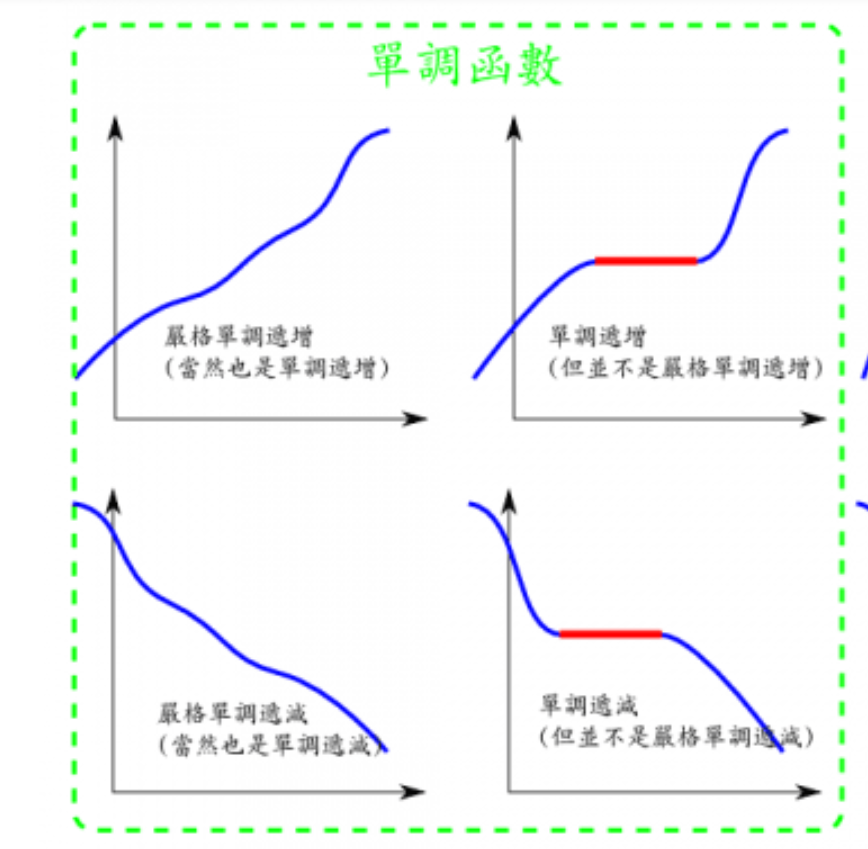

In [38]:
correlation_pearson = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="pearson")
correlation_spearman = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="spearman")

print(f"相關係數: {correlation_pearson:.4f}")
print(f"相關係數: {correlation_spearman:.4f}")

相關係數: -0.1014
相關係數: -0.0909


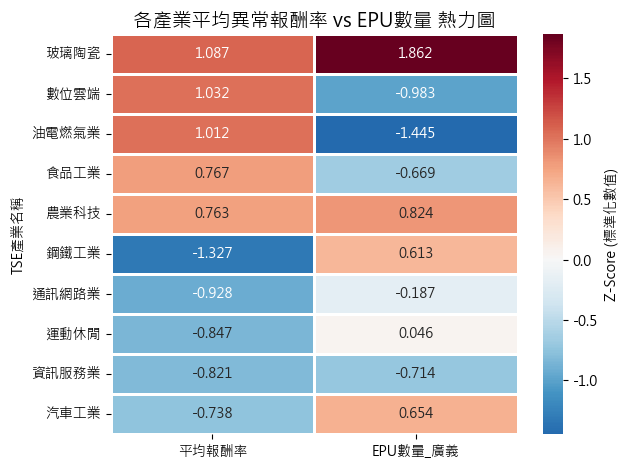

In [35]:
import matplotlib.pyplot as plt
df_norm = (df_extreme_return_EPU - df_extreme_return_EPU.mean()) / df_extreme_return_EPU.std()
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解決負號無法顯示的問題

sns.heatmap(df_norm, 
            annot=df_norm,           # 在格子裡顯示「原始數值」
            fmt=".3f",          # 數值格式：小數點後3位
            cmap="RdBu_r",      # 色票：紅藍配色 (Red-Blue reversed)，紅色代表高值
            center=0,           # 將顏色中心點設為 0 (平均值)
            linewidths=1,       # 格子邊框寬度
            cbar_kws={'label': 'Z-Score (標準化數值)'} # 色條標籤
           )

plt.title("各產業平均異常報酬率 vs EPU數量 熱力圖", fontsize=14)
plt.yticks(rotation=0) # 讓y軸文字轉正
plt.tight_layout()
plt.show()

#### 用OLS模型進行迴歸分析
#### 模組使用 : statsmodels
#### e.g : 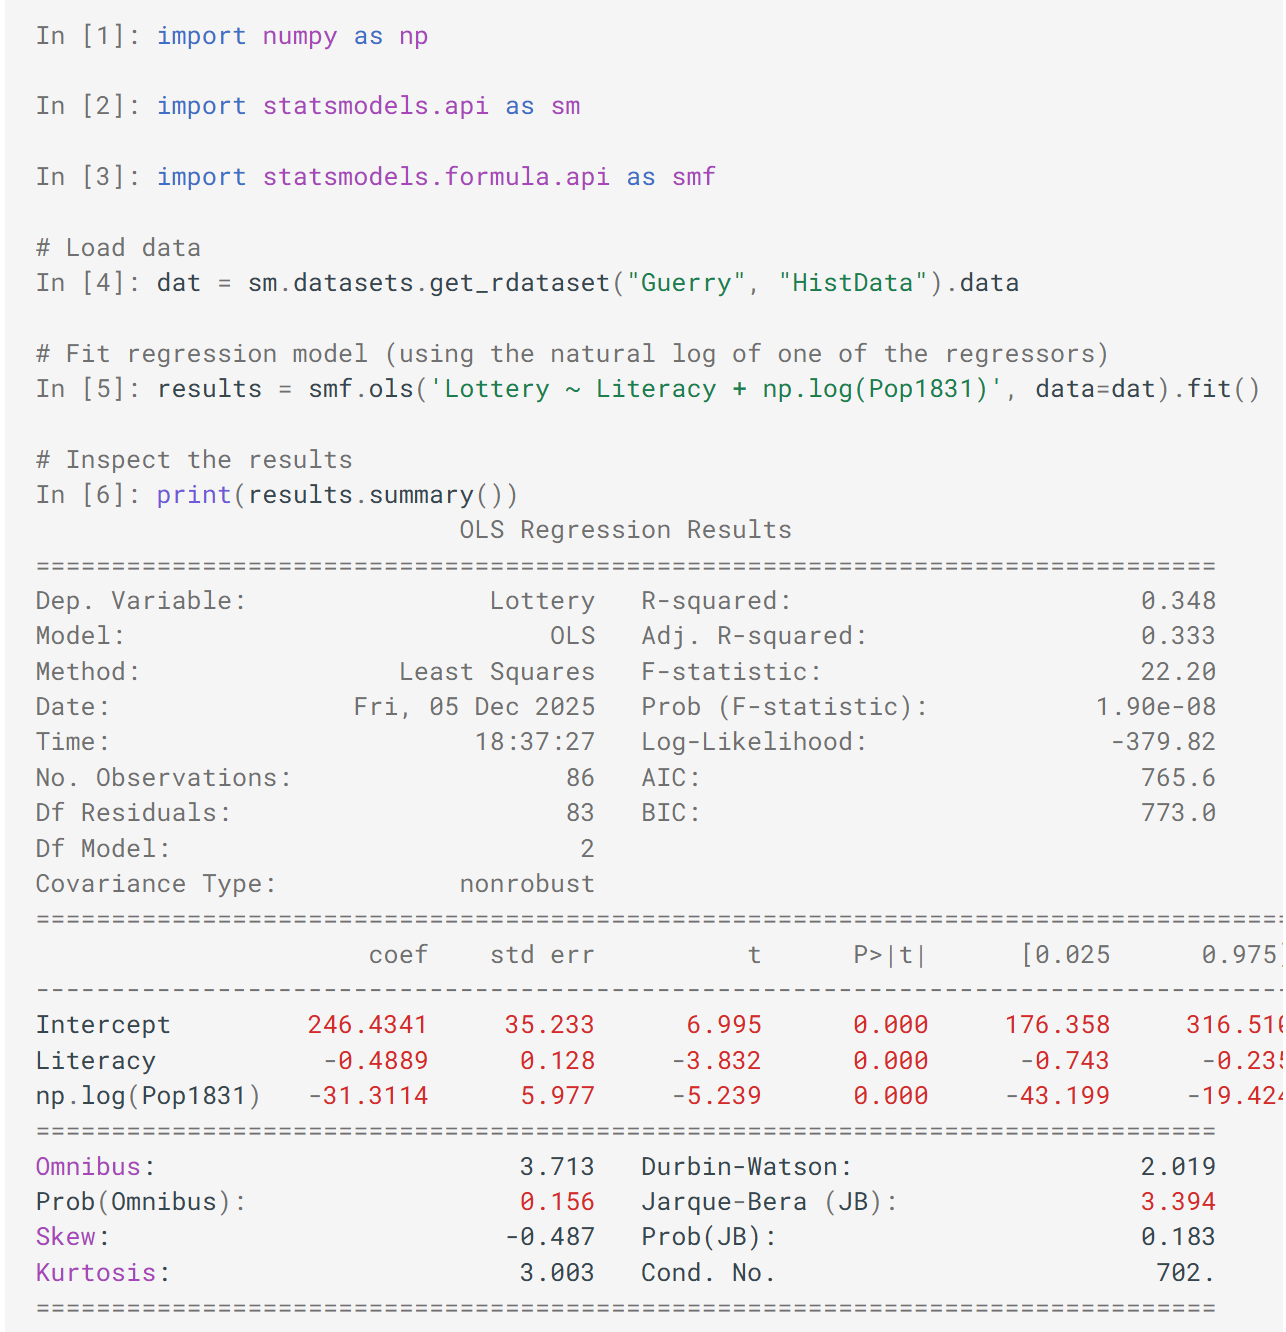

### <span style= "color : #a6440e"> 統計結果 : 顯著 ( p-value = 0.044 < 5% ) </span>
### 95% 信賴區間 -->  -0.097 ~ -0.002  
### coef = -0.0495 --> EPU每上升1單位，報酬率降低4.95%
### 跟熱力圖結果不同原因 : 排除outlier , 例如玻璃陶瓷產業 --> 事件期間內可能受其他非系統風險因素的影響  

In [82]:
# Y=應變數 , X =自變數
import statsmodels.api as sm
x=df_extreme_return_EPU["EPU數量_廣義"]
y=df_extreme_return_EPU["產業累計報酬率"]
X_const = sm.add_constant(x)
print(x)
print(X_const)
model=sm.OLS(y,X_const).fit()
model_noConst=sm.OLS(y,x).fit()

print(f"--- OLS 迴歸分析結果 ---")
 # 只印出係數表
print(model.summary().tables[1])
print(model_noConst.summary().tables[1])
print("-" * 30)


TSE產業名稱
玻璃陶瓷     2.800000
數位雲端     0.606061
油電燃氣業    0.250000
食品工業     0.848485
農業科技     2.000000
鋼鐵工業     1.836735
通訊網路業    1.219780
運動休閒     1.400000
資訊服務業    0.813953
汽車工業     1.868421
Name: EPU數量_廣義, dtype: float64
         const  EPU數量_廣義
TSE產業名稱                 
玻璃陶瓷       1.0  2.800000
數位雲端       1.0  0.606061
油電燃氣業      1.0  0.250000
食品工業       1.0  0.848485
農業科技       1.0  2.000000
鋼鐵工業       1.0  1.836735
通訊網路業      1.0  1.219780
運動休閒       1.0  1.400000
資訊服務業      1.0  0.813953
汽車工業       1.0  1.868421
--- OLS 迴歸分析結果 ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3986      9.177     -0.915      0.387     -29.560      12.763
EPU數量_廣義      -1.7095      5.928     -0.288      0.780     -15.379      11.960
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
stat_outcome=pd.read_html(model.summary().tables[1].as_html(),header=0, index_col=0)[0]
stat_outcome.to_csv("EPU_累計報酬率_extreme5.csv",encoding='utf-8-sig')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\user\AppData\Local\Temp\ipykernel_15820\356073118.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat_outcome=pd.read_html(model.summary().tables[1].as_html(),header=0, index_col=0)[0]


#### 用pairplot觀察變數之間的關係

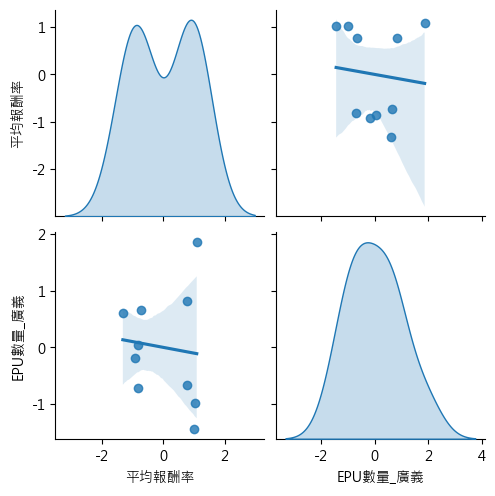

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_norm,
             kind="reg", 
             diag_kind="kde",
             height=2.5)

#### 擴大樣本 : 檢視所有產業下 EPU 與市場表現(累計報酬率)之關聯

In [23]:
if "Unnamed: 182" in return_industry.columns:
    return_industry=return_industry.drop(columns="Unnamed: 182")

elif "產業平均值" in return_industry.columns:
    return_industry=return_industry.drop(columns="產業平均值")

return_industry["產業累計報酬率"]=return_industry.sum(axis=1)

In [11]:
df_fs_EPU=df_fs_return.groupby("TSE產業名稱")["EPU數量_廣義(含政治)"].mean()
df_return_EPU=pd.concat([return_industry["累計異常報酬率"],df_fs_EPU],axis=1)
df_norm_allIndus=(df_return_EPU-df_return_EPU.mean())/df_return_EPU.std()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def plot_zscore_heatmap(df, title, figsize=(8, 6), output_filename=None):
    """
    繪製「標準化熱力圖」：顏色代表 Z-Score (相對強弱)，數字代表原始數值。
    
    參數:
    ----------
    df : pd.DataFrame
        原始資料 (index 為產業名稱，columns 為變數)。
    title : str
        圖表標題。
    figsize : tuple
        圖表大小 (寬, 高)。
    output_filename : str (選填)
        若提供檔名 (如 'heatmap.png')，會自動儲存圖片。
    """
    
    # 1. 字型設定 (確保中文顯示正常)
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    plt.rcParams['axes.unicode_minus'] = False

    # 2. 計算 Z-Score 標準化 (用於決定顏色深淺)
    # 公式：(數值 - 平均值) / 標準差
    df_norm = (df - df.mean()) / df.std()

    # 3. 建立畫布
    plt.figure(figsize=figsize)

    # 4. 繪製熱力圖
    sns.heatmap(
        df_norm,           # 資料來源 (決定顏色)：使用標準化後的 Z-Score
        annot=df,          # 格子數字 (決定內容)：使用 df (原始數值)，方便閱讀真實數據
        fmt=".3f",         # 數值格式：小數點後3位
        cmap="RdBu_r",     # 色票：紅藍配色
        center=0,          # 顏色中心點設為 0
        linewidths=1,      # 格子邊框寬度
        cbar_kws={'label': 'Z-Score (標準化數值)'} # 色條標籤
    )

    # 5. 設定標題與軸標籤
    plt.title(title, fontsize=14, pad=20) # pad 增加標題與圖的距離
    plt.yticks(rotation=0) # 讓 y 軸產業名稱轉正
    plt.tight_layout()     # 自動調整版面，避免文字被切掉

    # 6. 存檔與顯示
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"✅ 圖表已儲存為：{output_filename}")

    plt.show()



✅ 圖表已儲存為：EPUpolitics_cumabReturn_industry.png


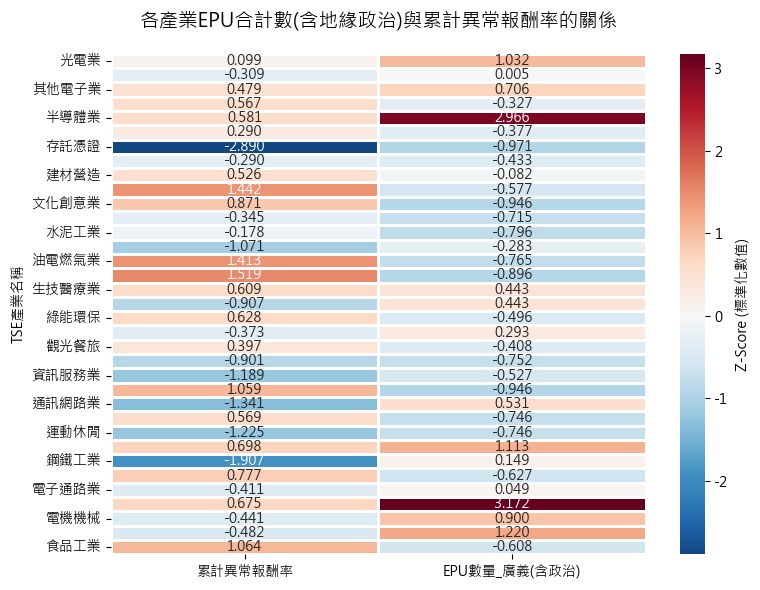

In [16]:
plot_zscore_heatmap(df_norm_allIndus, title="各產業EPU合計數(含地緣政治)與累計異常報酬率的關係", figsize=(8, 6), output_filename="EPUpolitics_cumabReturn_industry.png")

In [13]:
import statsmodels.api as sm
x_allIndus=df_return_EPU["EPU數量_廣義(含政治)"]
y_allIndus=df_return_EPU["累計異常報酬率"]
X_const_allIndus = sm.add_constant(x_allIndus)
model_allIndus=sm.OLS(y_allIndus,X_const_allIndus).fit()

print(f"--- OLS 迴歸分析結果 ---")
 # 只印出係數表
print(model_allIndus.summary().tables[1])

--- OLS 迴歸分析結果 ---
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.2173      3.433     -2.394      0.023     -15.201      -1.233
EPU數量_廣義(含政治)    -0.7563      1.007     -0.751      0.458      -2.805       1.293


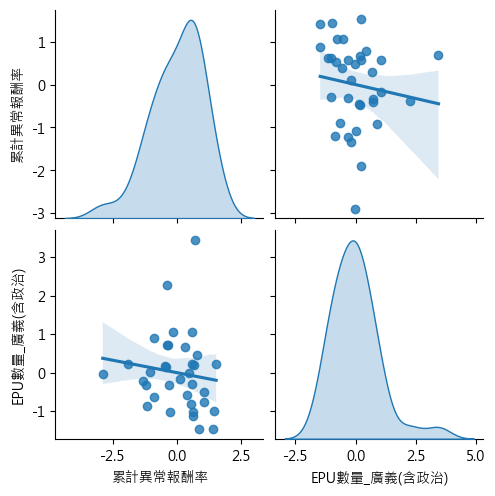

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_norm_allIndus,
             kind="reg", 
             diag_kind="kde",
             height=2.5)

### 下圖顯示 : 當相關係數=0時 ， 發生機率幾近為0 

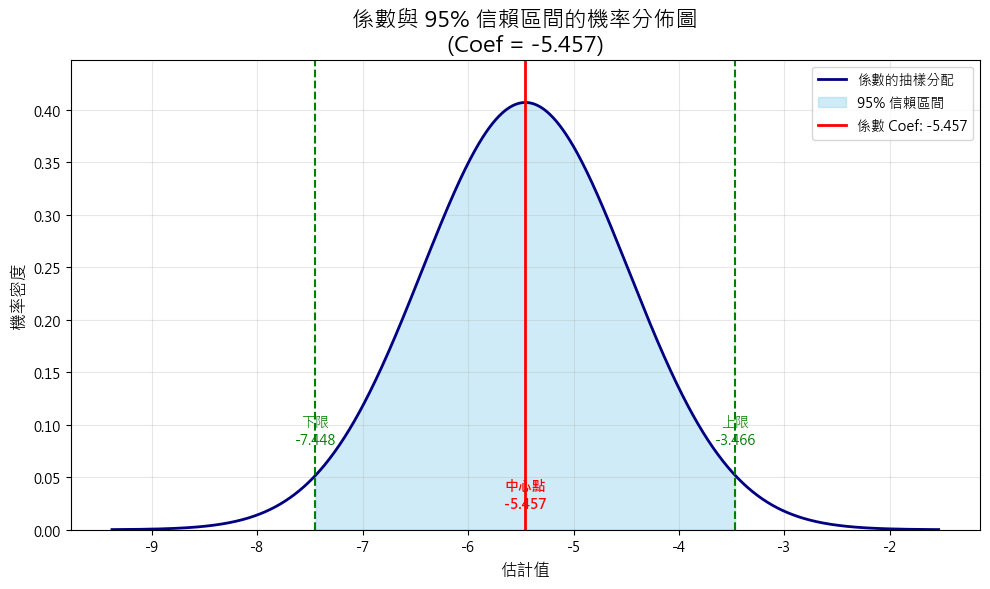

In [56]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. 設定數據 (來自您的 OLS 截圖)
coef = -5.4570       # 係數 (分佈的中心)
std_err = 0.980      # 標準誤 (分佈的胖瘦/標準差)
ci_lower = -7.448    # 信賴區間下限
ci_upper = -3.466    # 信賴區間上限

# 2. 設定畫布與字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))

# 3. 產生 X 軸數據 (以係數為中心，往左右各延伸 4 倍標準誤)
x = np.linspace(coef - 4*std_err, coef + 4*std_err, 1000)
# 產生 Y 軸數據 (常態分佈機率密度函數)
y = stats.norm.pdf(x, coef, std_err)

# 4. 繪製鐘形曲線
plt.plot(x, y, label='係數的抽樣分配', color='navy', lw=2)

# 5. 繪製信賴區間 (95% 信心水準)
plt.fill_between(x, y, where=(x >= ci_lower) & (x <= ci_upper), 
                 color='skyblue', alpha=0.4, label='95% 信賴區間')

# 6. 標示關鍵位置
# A. 係數 (中心點)
plt.axvline(x=coef, color='red', linestyle='-', lw=2, label=f'係數 Coef: {coef}')
plt.text(coef, max(y)*0.05, f'中心點\n{coef}', color='red', ha='center', fontweight='bold')

# B. 信賴區間下限
plt.axvline(x=ci_lower, color='green', linestyle='--', lw=1.5)
plt.text(ci_lower, max(y)*0.2, f'下限\n{ci_lower}', color='green', ha='center')

# C. 信賴區間上限
plt.axvline(x=ci_upper, color='green', linestyle='--', lw=1.5)
plt.text(ci_upper, max(y)*0.2, f'上限\n{ci_upper}', color='green', ha='center')

# 7. 圖表修飾
plt.title(f'係數與 95% 信賴區間的機率分佈圖\n(Coef = {coef})', fontsize=16)
plt.xlabel('估計值', fontsize=12)
plt.ylabel('機率密度', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(0, max(y)*1.1)

plt.tight_layout()
plt.show()

#### 將產業樣本拆分成AI產業與非AI產業

In [15]:
AI_industry=["半導體業","電子零組件","其他電子業","電器電纜","電腦及週邊設備業"]
df_return_EPU_AI=df_return_EPU[df_return_EPU.index.isin(AI_industry)]
df_return_EPU_NonAI=df_return_EPU[df_return_EPU.index.isin(AI_industry)==False]

In [16]:
df_norm_AIindus=(df_return_EPU_AI-df_return_EPU_AI.mean())/df_return_EPU_AI.std()
df_norm_NonAIindus=(df_return_EPU_NonAI-df_return_EPU_NonAI.mean())/df_return_EPU_NonAI.std()

✅ 圖表已儲存為：EPU_cumabReturn_AIindustry.png


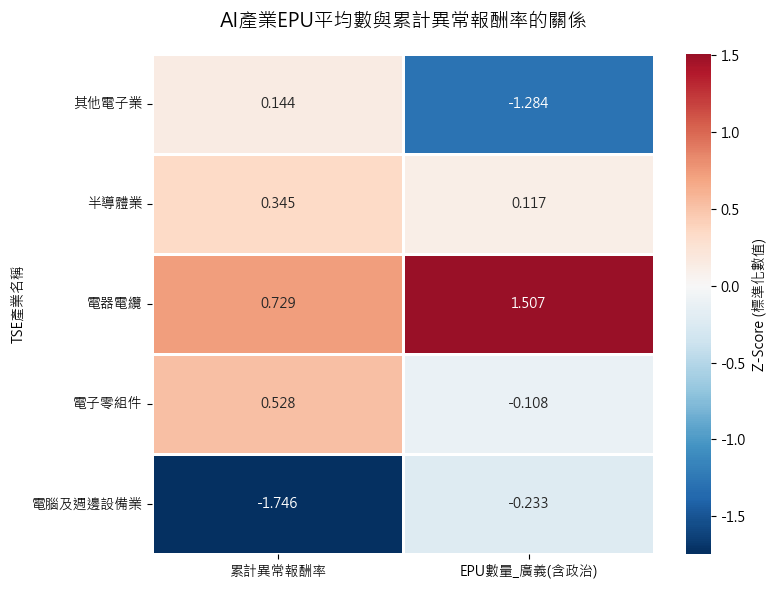

In [17]:
plot_zscore_heatmap(df_norm_AIindus, title="AI產業EPU平均數與累計異常報酬率的關係", figsize=(8, 6), output_filename="EPU_cumabReturn_AIindustry.png")

✅ 圖表已儲存為：EPU_cumabReturn_NonAIindustry.png


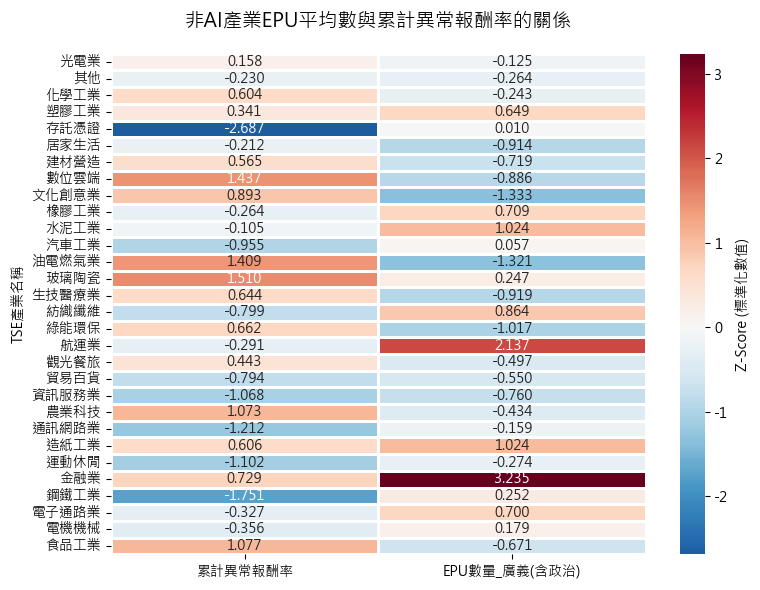

In [18]:
plot_zscore_heatmap(df_norm_NonAIindus, title="非AI產業EPU平均數與累計異常報酬率的關係", figsize=(8, 6), output_filename="EPU_cumabReturn_NonAIindustry.png")

#### 統計顯著性函式

In [23]:
import statsmodels.api as sm
import pandas as pd

def run_ols_regression(df, x_col, y_col, add_intercept=True):
    """
    執行 OLS 簡單線性迴歸並印出係數表。
    
    參數:
    ----------
    df : pd.DataFrame
        包含資料的 DataFrame。
    x_col : str
        自變數 (X) 的欄位名稱 (例如: 'EPU數量_廣義')。
    y_col : str
        應變數 (Y) 的欄位名稱 (例如: '產業累計報酬率')。
    add_intercept : bool
        是否加入截距項 (常數項)。預設為 True (強烈建議保留，除非您確定迴歸線必過原點)。
        
    回傳:
    ----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        訓練好的模型物件，可用於後續分析 (如 model.params, model.pvalues)。
    """
    
    # 1. 準備資料
    # 使用 copy() 避免修改到原始 DataFrame
    X = df[x_col].copy()
    Y = df[y_col].copy()
    X_const=sm.add_constant(X)
    
    
    
    # 3. 建立模型並擬合
    # 注意：這裡傳入的是處理過的 X (可能包含截距)
    model = sm.OLS(Y, X_const).fit()
    
    # 4. 印出結果
    print(f"=========================================================")
    print(f"   OLS 回歸分析: {y_col} (Y) ~ {x_col} (X)")
    print(f"=========================================================")
    print("--- 係數表 (Coefficients) ---")
    print(model.summary().tables[1])
    print("-" * 60)
    
    return model

In [24]:
run_ols_regression(df_return_EPU_AI, "EPU數量_廣義(含政治)", "累計異常報酬率", add_intercept=True)

   OLS 回歸分析: 累計異常報酬率 (Y) ~ EPU數量_廣義(含政治) (X)
--- 係數表 (Coefficients) ---
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -26.6573     33.324     -0.800      0.482    -132.709      79.395
EPU數量_廣義(含政治)     5.9063      9.887      0.597      0.592     -25.559      37.372
------------------------------------------------------------


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


#### 統計結果 : 加入常數項後不顯著，可能需改善EPU統計方式

In [26]:
run_ols_regression(df_return_EPU_NonAI, "EPU數量_廣義(含政治)", "累計異常報酬率", add_intercept=True)

   OLS 回歸分析: 累計異常報酬率 (Y) ~ EPU數量_廣義(含政治) (X)
--- 係數表 (Coefficients) ---
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.5435      3.630     -2.354      0.026     -15.978      -1.109
EPU數量_廣義(含政治)    -0.8683      1.063     -0.817      0.421      -3.046       1.309
------------------------------------------------------------


####  若不分產業別

In [27]:
import statsmodels.api as sm
import numpy as np
x_all=np.log1p(df_fs_return["EPU數量_廣義(含政治)"])
y_all=df_fs_return.iloc[:,52:183].sum(axis=1)
X_const_all = sm.add_constant(x_all)
model_all=sm.OLS(y_all,X_const_all).fit()

print(f"--- OLS 迴歸分析結果 ---")
 # 只印出係數表
print(model_all.summary().tables[1])

--- OLS 迴歸分析結果 ---
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -10.7993      1.173     -9.210      0.000     -13.099      -8.500
EPU數量_廣義(含政治)     0.8655      0.899      0.963      0.336      -0.898       2.629


In [4]:
df_all=pd.concat([x_all,y_all],axis=1)

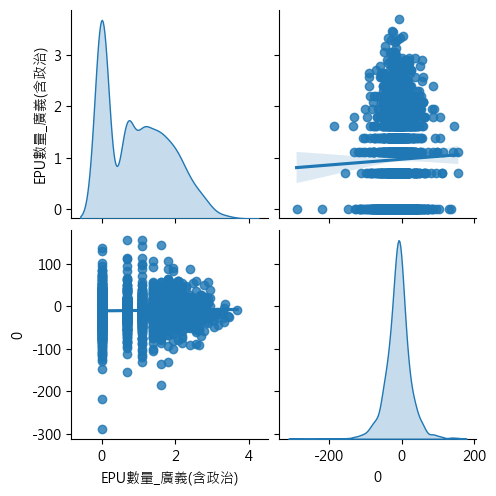

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解決負號無法顯示的問題
sns.pairplot(df_all,
             kind="reg", 
             diag_kind="kde",
             height=2.5)

## 改用smf.ols模組進行實證迴歸分析
## 先不納入SC變數

In [1]:
import pandas as pd
df_model=pd.read_csv("實證模型.csv",encoding='cp950')

#### 先將數據標準化 (Z分數) --> 降低誤差
#### 使用sklearn模組

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. 讀取資料 (加上 encoding 預防中文亂碼)
df_model = pd.read_csv("實證模型.csv", encoding="cp950")

# 2. 自動找出所有「數值型」的欄位名稱 (包含 int, float)
numeric_cols = df_model.select_dtypes(include=['number']).columns

# (選用) 排除不需要標準化的數值欄位：
# 雖然以下欄位是數字，但通常是「代碼」或「虛擬變數(Dummy Variable)」，標準化沒有意義
cols_to_exclude = ['代號', 'TSE 產業別']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# 3. 初始化 StandardScaler
scaler = StandardScaler()

# 4. 只針對篩選出來的數字欄位進行標準化轉換，並將結果覆蓋回原來的 DataFrame
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])

# 5. 將結果另存成新的 CSV 檔案
df_model.to_csv("實證模型_標準化.csv", index=False, encoding="utf-8-sig")

print("轉換完成！前五筆資料如下：")
print(df_model.head())

轉換完成！前五筆資料如下：
     代號  名稱  上市別  TSE 產業別 TSE產業名稱  員工人數-母公司  實收資本額(元)       資本額  資產總額_自然變數  \
0  1101  台泥  TSE        1    水泥工業  0.096724  4.084025  0.908172   2.762372   
1  1102  亞泥  TSE        1    水泥工業 -0.125908  1.728951  0.424058   2.383235   
2  1103  嘉泥  TSE        1    水泥工業 -0.244021  0.185095 -0.070801   1.036963   
3  1104  環泥  TSE        1    水泥工業 -0.108992  0.127087 -0.080774   0.926627   
4  1108  幸福  TSE        1    水泥工業 -0.150377 -0.030835 -0.113535   0.278023   

        槓桿比  ...  集團/非集團企業(量化)     EPU數量  EPU數量_廣義  EPU數量_廣義(含政治)    TESG分數  \
0 -0.095672  ...      0.894322  2.630366  1.791695       1.462801  0.201864   
1 -0.238982  ...      0.894322 -0.398011  5.717851       3.154462  1.251691   
2 -0.245732  ...      0.894322  4.144555  1.006464       0.737804 -0.441780   
3 -0.443530  ...     -1.118166 -0.398011 -0.563999      -0.712192  1.481862   
4 -0.063997  ...      0.894322 -0.398011 -0.563999      -0.712192 -0.228274   

   事件雷達轉換計分    環境構面分數    社會構面分數  公司治理構面分數 

### 假說1結果

In [3]:
import statsmodels.formula.api as smf
df_model.rename(columns={'EPU數量_廣義(含政治)': 'EPU數量_廣義_含政治'}, inplace=True)
df_model.rename(columns={'資產報酬率(2024全年)': '資產報酬率_2024全年'}, inplace=True)
model_smf=smf.ols(formula="累計報酬率 ~ EPU數量_廣義_含政治+資產總額_自然變數+資產報酬率_2024全年+槓桿比+現金比率+OI+EBIT+EBITDA+董事會規模+董事會獨立性+董事長兼任總經理+高階主管薪酬長期目標+集團控制型態_量化+現金充裕度+TESG分數+AI變數", data=df_model).fit()
print(model_smf.summary())
emperical_result=pd.read_html(model_smf.summary().tables[1].as_html(),header=0, index_col=0)[0]
emperical_result.to_html("實證模型結果.html", encoding='utf-8-sig')

                            OLS Regression Results                            
Dep. Variable:                  累計報酬率   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.112
Date:                Sun, 22 Feb 2026   Prob (F-statistic):            0.00612
Time:                        08:35:43   Log-Likelihood:                -2637.4
No. Observations:                1876   AIC:                             5309.
Df Residuals:                    1859   BIC:                             5403.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0028      0.023      0.122   

C:\Users\user\AppData\Local\Temp\ipykernel_23324\1036061054.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  emperical_result=pd.read_html(model_smf.summary().tables[1].as_html(),header=0, index_col=0)[0]


In [14]:
emperical_result_main=pd.read_html(model_smf.summary().tables[0].as_html(),header=0, index_col=0)[0]
emperical_result_main.to_html("實證模型主要統計量.html", encoding='utf-8-sig')
print(model_smf.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  累計報酬率   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.112
Date:                  週六, 21 二月 2026   Prob (F-statistic):            0.00612
Time:                        17:06:05   Log-Likelihood:                -2637.4
No. Observations:                1876   AIC:                             5309.
Df Residuals:                    1859   BIC:                             5403.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         


C:\Users\user\AppData\Local\Temp\ipykernel_26628\1945927288.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  emperical_result_main=pd.read_html(model_smf.summary().tables[0].as_html(),header=0, index_col=0)[0]


#### 假說1 : VIF檢定

In [15]:
vif_result = check_multicollinearity(model_smf)
vif_result.to_html("假說1診斷結果.html", encoding='utf-8-sig', index=False)

        🕵️ VIF 共線性診斷報告
        變數名稱    VIF_數值
      EBITDA 33.656366
        EBIT 33.634358
       董事會規模  2.066881
      董事會獨立性  2.052131
   資產總額_自然變數  1.954013
      TESG分數  1.458418
    董事長兼任總經理  1.206105
        現金比率  1.201420
資產報酬率_2024全年  1.169820
         槓桿比  1.135924
       現金充裕度  1.134049
EPU數量_廣義_含政治  1.094530
   集團控制型態_量化  1.093902
        AI變數  1.091247
          OI  1.027555
  高階主管薪酬長期目標  1.014870
   Intercept  1.008951
---------------------------------------
【判讀標準】:
✅ VIF < 5   : 安全，無共線性問題
⚠️ VIF 5~10  : 輕微/中度共線性，可忍受
🚨 VIF > 10  : 嚴重共線性，強烈建議剔除該變數！


### 假說2結果

In [4]:
import statsmodels.formula.api as smf
df_model.rename(columns={'EPU數量_廣義(含政治)': 'EPU數量_廣義_含政治'}, inplace=True)
df_model.rename(columns={'資產報酬率(2024全年)': '資產報酬率_2024全年'}, inplace=True)
df_model.rename(columns={'集團/非集團企業(量化)': '集團_非集團企業_量化'}, inplace=True)
model2_smf=smf.ols(formula="累計報酬率 ~ EPU數量_廣義_含政治*集團_非集團企業_量化+資產總額_自然變數*集團_非集團企業_量化+資產報酬率_2024全年*集團_非集團企業_量化+槓桿比*集團_非集團企業_量化+現金比率*集團_非集團企業_量化+OI*集團_非集團企業_量化+EBIT*集團_非集團企業_量化+EBITDA*集團_非集團企業_量化+董事會規模*集團_非集團企業_量化+董事會獨立性*集團_非集團企業_量化+董事長兼任總經理*集團_非集團企業_量化+高階主管薪酬長期目標*集團_非集團企業_量化+集團控制型態_量化*集團_非集團企業_量化+現金充裕度+TESG分數*集團_非集團企業_量化+AI變數", data=df_model).fit()
print(model2_smf.summary())


                            OLS Regression Results                            
Dep. Variable:                  累計報酬率   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.394
Date:                Sun, 22 Feb 2026   Prob (F-statistic):             0.0736
Time:                        08:35:56   Log-Likelihood:                -2632.6
No. Observations:                1876   AIC:                             5329.
Df Residuals:                    1844   BIC:                             5506.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [11]:
emperical_result_model2=pd.read_html(model2_smf.summary().tables[1].as_html(),header=0, index_col=0)[0]
emperical_result_model2.to_html("實證模型結果_假說2.html", encoding='utf-8-sig')

C:\Users\user\AppData\Local\Temp\ipykernel_26628\534461130.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  emperical_result_model2=pd.read_html(model2_smf.summary().tables[1].as_html(),header=0, index_col=0)[0]


#### 模型警示 : 條件數太大，導致模型不穩
#### 問題來源 : 變數的「量級 / 尺度」差異太大  + 強烈多重共線性
#### 解決方法 : 標準化 + 計算 VIF (變異數膨脹因子) ，刪除重複的變數
#### 可能需刪除變數 : EBIT + EBITDA + OI

In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(model):
    """
    自動計算 OLS 模型的 VIF 值，找出多重共線性的元兇。
    """
    # 1. 從訓練好的模型中，自動抓取出所有的自變數矩陣 (X) 與名稱
    X = model.model.exog
    names = model.model.exog_names
    
    # 2. 準備一個空的 DataFrame 來存放結果
    vif_data = pd.DataFrame()
    vif_data["變數名稱"] = names
    
    # 3. 跑迴圈計算每一個變數的 VIF 值
    # (這可能需要幾秒鐘的時間，因為它會在背後跑很多次迴歸)
    vif_data["VIF_數值"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    
    # 4. 依照 VIF 數值由大到小排序，把最嚴重的排在最上面
    vif_data = vif_data.sort_values(by="VIF_數值", ascending=False).reset_index(drop=True)
    
    # 5. 印出診斷報告
    print("=======================================")
    print("        🕵️ VIF 共線性診斷報告")
    print("=======================================")
    print(vif_data.to_string(index=False))
    print("---------------------------------------")
    print("【判讀標準】:")
    print("✅ VIF < 5   : 安全，無共線性問題")
    print("⚠️ VIF 5~10  : 輕微/中度共線性，可忍受")
    print("🚨 VIF > 10  : 嚴重共線性，強烈建議剔除該變數！")
    
    return vif_data

# --- 執行健檢 ---
# 假設您剛跑完的模型變數名稱叫做 model
# 如果您的模型叫其他名字 (例如 model_3)，請自行替換括號內的名稱
vif2_result = check_multicollinearity(model2_smf)
vif2_result.to_html("假說2診斷結果.html", encoding='utf-8-sig', index=False)


        🕵️ VIF 共線性診斷報告
                    變數名稱    VIF_數值
        EBIT:集團_非集團企業_量化 52.918244
                    EBIT 44.906656
      EBITDA:集團_非集團企業_量化 42.371334
                  EBITDA 34.326271
                      OI 13.652028
          OI:集團_非集團企業_量化 13.627802
               資產總額_自然變數  2.215778
                   董事會規模  2.114690
       董事會規模:集團_非集團企業_量化  2.091109
                  董事會獨立性  2.081951
      董事會獨立性:集團_非集團企業_量化  2.041048
   資產總額_自然變數:集團_非集團企業_量化  1.960548
         槓桿比:集團_非集團企業_量化  1.801804
                     槓桿比  1.785451
                  TESG分數  1.475288
      TESG分數:集團_非集團企業_量化  1.425822
              高階主管薪酬長期目標  1.394271
  高階主管薪酬長期目標:集團_非集團企業_量化  1.387466
                董事長兼任總經理  1.286630
    董事長兼任總經理:集團_非集團企業_量化  1.274114
                    現金比率  1.267382
資產報酬率_2024全年:集團_非集團企業_量化  1.266060
            資產報酬率_2024全年  1.263465
        現金比率:集團_非集團企業_量化  1.247333
             集團_非集團企業_量化  1.212702
               Intercept  1.185584
                   現金充裕度  1.1827

#### 假說1修改 : 測試刪除EBIT + EBITDA後之效果
#### 加入穩健標準誤 : 修正異質變異--> 小型股波動大，而大型股可能股價較穩定的殘差問題

In [7]:
model_smf_revised=smf.ols(formula="累計報酬率 ~ EPU數量_廣義_含政治+資產總額_自然變數+資產報酬率_2024全年+槓桿比+現金比率+OI+董事會規模+董事會獨立性+董事長兼任總經理+高階主管薪酬長期目標+集團控制型態_量化+現金充裕度+TESG分數+AI變數", data=df_model,cov_type='HC3').fit()
print(model_smf_revised.summary())
emperical_result_revised=pd.read_html(model_smf_revised.summary().tables[1].as_html(),header=0, index_col=0)[0]
emperical_result_revised.to_html("實證模型結果_修正後.html", encoding='utf-8-sig')

                            OLS Regression Results                            
Dep. Variable:                  累計報酬率   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.347
Date:                Sun, 22 Feb 2026   Prob (F-statistic):            0.00320
Time:                        08:51:34   Log-Likelihood:                -2638.9
No. Observations:                1877   AIC:                             5308.
Df Residuals:                    1862   BIC:                             5391.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0028      0.023      0.122   

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)
C:\Users\user\AppData\Local\Temp\ipykernel_23324\4087522832.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  emperical_result_revised=pd.read_html(model_smf_revised.summary().tables[1].as_html(),header=0, index_col=0)[0]
